In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>


# Intro

I recently published a post about applying [deep learning to the stock market](https://medium.com/@TalPerry/deep-learning-the-stock-market-df853d139e02#.e33ao345g). This Notebook is an initial sketch of the implementation. People approach the market to make money, and I am no exception, so it may come as some suprise that I am giving this away. In fact, I don't think this implementation does make money. But it does illustrate a variety of concepts that are important for data science, deep learning and the application of both to finance. I learnt almost everything I know from tutorials like this one on the internet, and I hope someone will learn a thing or two from this

## What's in this thing?

This notebook goes through the full the process of implementing the ideas I layed out in the post. That is it covers
* Preparing the data
* Building a baseline
* Implementing a DL model

## A (more or less) standard data science work flow

### Defining the problem you want to solve
I think all three of those stages are important, and in many respects they are ordered by both importance and the order in which I approach them. My first step in this process was writing that post (4.5K words) explaining in relatively simple terms what I want to do and why. 

### Collecting data
The next stage was collecting data, this actually took me a while and I ended up going with a freely availble dataset you can download [here](https://quantquote.com/historical-stock-data). 

### Reconciling the problem and the data
Once I had an idea of what problem I wanted to solve and I had some data I went about getting the data into a shape  I could work with. 

### Making a baseline
Next I built a baseline model. A baseline doesn't need to be good, but it needs to be something you can compare your actual model to, so that you can know if all the fancy complicated things you did are any better than something simple. This is also a good point to choose how to measure your models performance.

### Testing the idea
I ended up bulding to baselines. One is a simple logistic regression and the other is a 3 layer feed forward network, or if you like big words, a multi layer perceptron. I made the first because I wanted a baseline and the second because I wanted to see if the additional complexity and computation cost of an RNN added benefit over a simpler network

# Data Prepaparation
Maybe its different for the more fortunate but in my experience 80% of the work in data science is data engineering. If I had to break that down even more it would be 20% "science", 20% engineering and 60% finding the right, clean data. 
For the project at hand I wanted a lot of data for many stocks. My "production" version uses slightly different data but for the POC using 10 years of the S&P was enough to prover my point.

In case you missed it, the S&P500 is an index of 500 stocks that is updated once every 3 months. For POC purposes using daily data is sufficient and I ended up finding a free data set [here](https://quantquote.com/historical-stock-data). You can download it and point the *datapath* variable to point at it and runs this notebook yourself
This notebook explores the data, joins all the stocks and creates targets


## preliminaries
So first we need to import some libraries and define some helper functions
* **get_ticker** applies a regex to the filename we are looking at and extracts the ticker from it
* **ret calculates** to log return between two points. Returns should be observed in log space because
    * Returns are log-normally distributed so log returns are follow a normal distribution
    * You can some log returns instead of taking products which makes life easier
* **zscore** maps a pandas series to it's zscore. In other words, it makes it have mean 0 and variance 1
    * It's good to have variablised normalized like this as it makes all of the dimensions of your data behave the same
    * It doesn't make sense to apply a z-score to distributions that don't (more or less) folllow the normal distribution. So check your variables first and if they don't follow a normal distribution transform them so that they do are use other scaling methods

In [2]:
import pandas as pd
import os
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
datapath = './daily'
filepath = os.path.join(datapath,os.listdir('./daily')[0])

In [4]:
import re
ticker_regex = re.compile('.+_(?P<ticker>.+)\.csv')
get_ticker =lambda x :ticker_regex.match(x).groupdict()['ticker']
print(filepath,get_ticker(filepath))

('./daily/table_a.csv', 'a')


In [5]:
ret = lambda x,y: log(y/x) #Log return 
zscore = lambda x:(x -x.mean())/x.std() # zscore

## First peak at the data
I blah blahed alot without actually looking at the data. lets load it. I use the pandas library to rad a single CSV. Since the data had no column headers I specified them. I don't know what the first column is so I labeled it UNK.
Notice that the index, which is the real first column in the original data, is a date but in a string pandas didn't understand. We're going to parse it to a datetime object later so that pandas preserves the right order. 

In [6]:
D = pd.read_csv(filepath,header=None,names=['UNK','o','h','l','c','v']) #Load the dataframe with headers

In [7]:
D.head() #Lets peack at it

,UNK,o,h,l,c,v
19991118,0,42.2076,46.3820,37.4581,39.1928,4.398181e+07
19991119,0,39.8329,39.8885,36.9293,37.6251,1.139020e+07
19991122,0,38.3208,40.0091,37.1613,39.9442,4.654716e+06
19991123,0,39.4247,40.4729,37.3375,37.5138,4.268903e+06
19991124,0,37.2262,38.9052,37.1056,38.0889,3.602367e+06


## Extracting Relevant Data
We don't care about prices, just about their fluctations. So we'll give the log return of the various prices, and take a zscore so everything is nice. 
Also, extract the ticker from the file name and add it to the df as a column.


In [8]:
def make_inputs(filepath):
    D = pd.read_csv(filepath,header=None,names=['UNK','o','h','l','c','v']) #Load the dataframe with headers
    D.index = pd.to_datetime(D.index,format='%Y%m%d') # Set the indix to a datetime
    Res = pd.DataFrame()
    ticker = get_ticker(filepath)

    Res['c_2_o'] = zscore(ret(D.o,D.c))
    Res['h_2_o'] = zscore(ret(D.o,D.h))
    Res['l_2_o'] = zscore(ret(D.o,D.l))
    Res['c_2_h'] = zscore(ret(D.h,D.c))
    Res['h_2_l'] = zscore(ret(D.h,D.l))
    Res['c1_c0'] = ret(D.c,D.c.shift(-1)).fillna(0) #Tommorows return 
    Res['vol'] = zscore(D.v)
    Res['ticker'] = ticker
    return Res
Res = make_inputs(filepath)

In [9]:
Res.head() # Lets look at what we got

,c_2_o,h_2_o,l_2_o,c_2_h,h_2_l,c1_c0,vol,ticker
1999-11-18,-2.875906,3.942736,-5.176517,-8.313468,-7.250098,-0.040822,22.437430,a
1999-11-19,-2.218402,-0.819624,-2.967516,-2.283408,-1.726542,0.059812,4.609137,a
1999-11-22,1.572687,1.318667,-0.694121,0.829875,-1.595383,-0.062775,0.924687,a
1999-11-23,-1.936005,0.453801,-1.890881,-3.243109,-1.870150,0.015214,0.713638,a
1999-11-24,0.857645,1.369972,0.695310,-0.243544,-0.524722,0.003161,0.349030,a


In [10]:
Res.corr() #Quick check to see we didn't mess it up. All values should be different, otherwise we repeated a variable

,c_2_o,h_2_o,l_2_o,c_2_h,h_2_l,c1_c0,vol
c_2_o,1.000000,0.713152,0.699395,0.661722,-0.003292,0.046037,-0.048971
h_2_o,0.713152,1.000000,0.207554,-0.053673,-0.622913,0.018455,0.172745
l_2_o,0.699395,0.207554,1.000000,0.774273,0.635967,0.063724,-0.218147
c_2_h,0.661722,-0.053673,0.774273,1.000000,0.661533,0.045840,-0.254513
h_2_l,-0.003292,-0.622913,0.635967,0.661533,1.000000,0.036401,-0.310731
c1_c0,0.046037,0.018455,0.063724,0.045840,0.036401,1.000000,0.003882
vol,-0.048971,0.172745,-0.218147,-0.254513,-0.310731,0.003882,1.000000


## Generating the full data set
I'll iterate over each file, run the above and concat to a final df. Then we'll pivot

In [11]:
Final = pd.DataFrame()
for f in os.listdir(datapath):
    filepath = os.path.join(datapath,f)
    if filepath.endswith('.csv'):
        Res = make_inputs(filepath)
        Final = Final.append(Res)

In [12]:
Final.head()

,c_2_o,h_2_o,l_2_o,c_2_h,h_2_l,c1_c0,vol,ticker
1999-11-18,-2.875906,3.942736,-5.176517,-8.313468,-7.250098,-0.040822,22.437430,a
1999-11-19,-2.218402,-0.819624,-2.967516,-2.283408,-1.726542,0.059812,4.609137,a
1999-11-22,1.572687,1.318667,-0.694121,0.829875,-1.595383,-0.062775,0.924687,a
1999-11-23,-1.936005,0.453801,-1.890881,-3.243109,-1.870150,0.015214,0.713638,a
1999-11-24,0.857645,1.369972,0.695310,-0.243544,-0.524722,0.003161,0.349030,a


In [13]:
pivot_columns = Final.columns[:-1]
P = Final.pivot_table(index=Final.index,columns='ticker',values=pivot_columns) # Make a pivot table from the data

In [14]:
P.head()

c_2_o                                                             \
ticker         a        aa      aapl abbv       abc       abt       ace acn   
1998-01-02   NaN -0.017649  6.991394  NaN  0.047250  1.845516 -0.601609 NaN   
1998-01-05   NaN  0.373488 -1.224062  NaN -0.160945  0.031659 -0.234577 NaN   
1998-01-06   NaN -0.718569  6.857266  NaN -1.102853 -0.473164  0.452262 NaN   
1998-01-07   NaN  0.980669 -3.007557  NaN  0.553079  0.746779  0.137372 NaN   
1998-01-08   NaN -1.828950  1.388888  NaN  0.488170 -0.221620 -0.484264 NaN   

                               ...       vol                                \
ticker           act      adbe ...        xl      xlnx       xom      xray   
1998-01-02 -0.911471 -0.375461 ... -0.676802  1.391497 -1.045626 -1.147952   
1998-01-05  2.090086  0.791331 ... -0.621025  1.019607 -0.615370 -0.556684   
1998-01-06 -1.239961  1.451409 ... -0.634169  0.020195 -0.527923 -1.131583   
1998-01-07 -0.878292 -0.534781 ... -0.616242  1.023705 -0.134130 -0.329006   
1998-01-08  1.300492  0.538778 ... -0.655003  0.645285 -0.907375 -1.066107   

                                                            
ticker           xrx xyl      yhoo       yum      zion zmh  
1998-01-02 -0.817355 NaN -0.368713 -0.678763 -0.724482 NaN  
1998-01-05 -0.757660 NaN  0.064841  0.980283 -0.735275 NaN  
1998-01-06 -0.629732 NaN  0.150071  1.697887 -0.683202 NaN  
1998-01-07 -0.504232 NaN -0.463651  0.515268 -0.635858 NaN  
1998-01-08 -0.560549 NaN -0.157777  0.235907 -0.605092 NaN  

[5 rows x 3500 columns]

### Flattening the pivot
source http://stackoverflow.com/questions/14507794/python-pandas-how-to-flatten-a-hierarchical-index-in-columns
At the end of this P is a flattened dataframe of all the entries for each stock, one day per row

In [15]:
mi = P.columns.tolist()

In [16]:
new_ind = pd.Index(e[1] +'_' + e[0] for e in mi)

In [17]:
P.columns = new_ind
P = P.sort(axis=1) # Sort by columns

/Users/mahui/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(....) is deprecated, use sort_index(.....)
  from ipykernel import kernelapp as app


In [18]:
P.head()

,a_c1_c0,a_c_2_h,a_c_2_o,a_h_2_l,a_h_2_o,a_l_2_o,a_vol,aa_c1_c0,aa_c_2_h,aa_c_2_o,...,zion_h_2_o,zion_l_2_o,zion_vol,zmh_c1_c0,zmh_c_2_h,zmh_c_2_o,zmh_h_2_l,zmh_h_2_o,zmh_l_2_o,zmh_vol
1998-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.017390,0.670259,-0.017649,...,0.246401,0.710284,-0.724482,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.022601,0.462520,0.373488,...,0.127875,0.710284,-0.735275,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001693,-0.088471,-0.718569,...,-0.677287,-1.264514,-0.683202,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.042290,1.002099,0.980669,...,-0.677287,-1.175835,-0.635858,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.024094,-2.074267,-1.828950,...,-0.202411,-2.278200,-0.605092,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
clean_and_flat = P.dropna(1)

In [20]:
target_cols = list(filter(lambda x: 'c1_c0' in x, clean_and_flat.columns.values))
input_cols  = list(filter(lambda x: 'c1_c0' not in x, clean_and_flat.columns.values))

In [21]:
InputDF = clean_and_flat[input_cols][:3900]
TargetDF = clean_and_flat[target_cols][:3900]

In [22]:
corrs = TargetDF.corr()

## Generating Targets
We now have an our inputs and targets, kind of. 
InputsDF has all the inputs we want to predict. Targets DF has the return of each stock each day. 
For starters, lets give a simpler target to predict than the reuturn of each stock, since we don't have much data. 


We're going to label the targets as either up (1) down (-1) or flat (0) days.
The top chart shows what would happen if we bought 1 dollar of ewach stock each day
The bottom chart shows what would happen if we longed the whole basket on (1) days, shorted it on down days (-1) and ignored it on  (0) days. 
You can see that this is a valuable target to predict.

In [23]:
num_stocks = len(TargetDF.columns)

In [24]:
TotalReturn = ((1-exp(TargetDF)).sum(1))/num_stocks # If i put one dollar in each stock at the close, this is how much I'd get back

In [25]:
def labeler(x):
    if x>0.0029:
        return 1
    if x<-0.00462:
        return -1
    else:
        return 0

In [26]:
Labeled = pd.DataFrame()
Labeled['return'] = TotalReturn
Labeled['class'] = TotalReturn.apply(labeler,1)
Labeled['multi_class'] = pd.qcut(TotalReturn,11,labels=range(11))

In [27]:
pd.qcut(TotalReturn,5).unique()

[(-0.00301, 0.00119], (0.00741, 0.0999], (0.00119, 0.00741], [-0.108, -0.00877], (-0.00877, -0.00301]]
Categories (5, object): [[-0.108, -0.00877] < (-0.00877, -0.00301] < (-0.00301, 0.00119] < (0.00119, 0.00741] < (0.00741, 0.0999]]

In [28]:
def labeler_multi(x):
    if x>0.0029:
        return 1
    if x<-0.00462:
        return -1
    else:
        return 0

In [29]:
Labeled['class'].value_counts()

 1    1301
 0    1301
-1    1298
Name: class, dtype: int64

In [30]:
Labeled['act_return'] = Labeled['class'] * Labeled['return']

array([<matplotlib.axes._subplots.AxesSubplot object at 0x115515dd0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x116a65a50>], dtype=object)

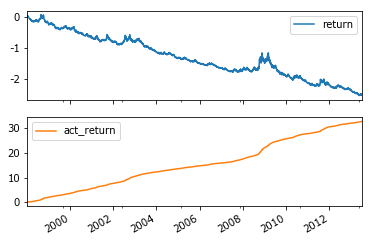

In [31]:
Labeled[['return','act_return']].cumsum().plot(subplots=True)

# Making a baseline

## Logistic Regression

In [32]:
from sklearn import linear_model
logreg = linear_model.LogisticRegression(C=1e5)

In [33]:
test_size=600

In [34]:
res = logreg.fit(InputDF[:-test_size],Labeled['multi_class'][:-test_size])

In [35]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(Labeled['multi_class'][-test_size:],res.predict(InputDF[-test_size:])))
print(confusion_matrix(Labeled['multi_class'][-test_size:],res.predict(InputDF[-test_size:])))

             precision    recall  f1-score   support

          0       0.20      0.04      0.06        52
          1       0.08      0.06      0.07        50
          2       0.09      0.17      0.11        60
          3       0.12      0.11      0.12        62
          4       0.10      0.06      0.07        50
          5       0.06      0.12      0.08        51
          6       0.15      0.23      0.18        60
          7       0.05      0.04      0.04        53
          8       0.06      0.06      0.06        54
          9       0.11      0.07      0.09        56
         10       0.00      0.00      0.00        52

avg / total       0.09      0.09      0.08       600

[[ 2  3 11  7  1  6  7  3  3  4  5]
 [ 1  3  8  8  7  7  6  2  3  2  3]
 [ 1  3 10  5  2 13  5 11  5  3  2]
 [ 1  5  9  7  3 15  6  2  8  4  2]
 [ 1  3  6  2  3  9 10  5  7  4  0]
 [ 0  4 12  3  2  6  6  4  5  6  3]
 [ 1  2 15  3  1 12 14  1  4  3  4]
 [ 0  4  8  4  3  8 11  2 10  3  0]
 [ 0  2 16  6  2  9 

In [36]:
Labeled['predicted_action'] = list(map(lambda x: -1 if x <5 else 0 if x==5 else 1,res.predict(InputDF)))
print(confusion_matrix(Labeled['class'][-test_size:],Labeled['predicted_action'][-test_size:]))

[[89 36 78]
 [72 35 93]
 [91 30 76]]


In [37]:
Labeled['pred_return'] = Labeled['predicted_action'] * Labeled['return']

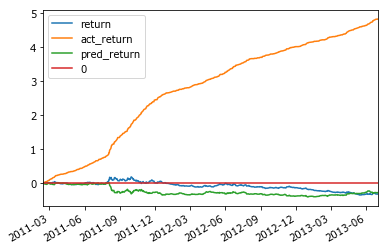

In [38]:
Res = Labeled[-test_size:][['return','act_return','pred_return']].cumsum()
Res[0] =0
Res.plot()

## Training a basic feed forward network
Here I'll use the tensorflow contrib.learn to quickly train a feed forward network. More of a benchmark than something I plan on using

In [60]:
import tensorflow as tf
from  tensorflow.contrib.learn.python.learn.estimators.dnn  import DNNClassifier
from tensorflow.contrib.layers import real_valued_column

In [61]:
Labeled['tf_class'] = Labeled['multi_class']
num_features = len(InputDF.columns)
dropout=0.2
hidden_1_size = 1000
hidden_2_size = 250
num_classes = Labeled.tf_class.nunique()
NUM_EPOCHS=100
BATCH_SIZE=50
lr=0.0001

In [62]:
train = (InputDF[:-test_size].values,Labeled.tf_class[:-test_size].values)
val = (InputDF[-test_size:].values,Labeled.tf_class[-test_size:].values)
NUM_TRAIN_BATCHES = int(len(train[0])/BATCH_SIZE)
NUM_VAL_BATCHES = int(len(val[1])/BATCH_SIZE)

In [63]:
len(InputDF)

3900

In [73]:
class Model():
    def __init__(self):
        global_step = tf.contrib.framework.get_or_create_global_step()
        self.input_data = tf.placeholder(dtype=tf.float32,shape=[None,num_features])
        self.target_data = tf.placeholder(dtype=tf.int32,shape=[None])
        self.dropout_prob = tf.placeholder(dtype=tf.float32,shape=[])
        with tf.variable_scope("ff"):
            droped_input = tf.nn.dropout(self.input_data,keep_prob=self.dropout_prob)
            
            layer_1 = tf.contrib.layers.fully_connected(
                num_outputs=hidden_1_size,
                inputs=droped_input,
            )
            layer_2 = tf.contrib.layers.fully_connected(
                num_outputs=hidden_2_size,
                inputs=layer_1,
            )
            self.logits = tf.contrib.layers.fully_connected(
                num_outputs=num_classes,
                activation_fn =None,
                inputs=layer_2,
            )
        with tf.variable_scope("loss"):
            
            self.losses = tf.nn.softmax_cross_entropy_with_logits(labels=self.target_data, logits=self.logits)
            mask = (1-tf.sign(1-self.target_data)) #Don't give credit for flat days
            mask = tf.cast(mask,tf.float32)            
            self.loss = tf.reduce_sum(self.losses)
        
        with tf.name_scope("train"):
          opt = tf.train.AdamOptimizer(lr)
          gvs = opt.compute_gradients(self.loss)
          self.train_op = opt.apply_gradients(gvs, global_step=global_step)
        
        with tf.name_scope("predictions"):
            self.probs = tf.nn.softmax(self.logits)
            self.predictions = tf.argmax(self.probs, 1)
            correct_pred = tf.cast(tf.equal(self.predictions, tf.cast(self.target_data,tf.int64)),tf.float64)
            self.accuracy = tf.reduce_mean(correct_pred)

In [74]:
with tf.Graph().as_default():
    model = Model()
    input_ = train[0]
    target = train[1]
    with tf.Session() as sess:
        init = tf.global_variables_initializer()
        sess.run([init])
        epoch_loss =0
        for e in range(NUM_EPOCHS):
            if epoch_loss >0 and epoch_loss <1:
                break
            epoch_loss =0
            for batch in range(0,NUM_TRAIN_BATCHES):
                
                start = batch*BATCH_SIZE
                end = start + BATCH_SIZE 
                feed = {
                    model.input_data:input_[start:end],
                    model.target_data:target[start:end],
                    model.dropout_prob:0.9
                            }
                
                _,loss,acc = sess.run(
                    [
                        model.train_op,
                        model.loss,
                        model.accuracy,
                    ]
                    ,feed_dict=feed
                )
                epoch_loss+=loss
            print('step - {0} loss - {1} acc - {2}'.format((1+batch+NUM_TRAIN_BATCHES*e),epoch_loss,acc))
                
        
        print('done training')
        final_preds =np.array([])
        final_probs =None
        for batch in range(0,NUM_VAL_BATCHES):
            
                start = batch*BATCH_SIZE
                end = start + BATCH_SIZE 
                feed = {
                    model.input_data:val[0][start:end],
                    model.target_data:val[1][start:end],
                    model.dropout_prob:1
                            }
                
                acc,preds,probs = sess.run(
                    [
                        model.accuracy,
                        model.predictions,
                        model.probs
                    ]
                    ,feed_dict=feed
                )
                print(acc)
                final_preds = np.concatenate((final_preds,preds),axis=0)
                if final_probs is None:
                    final_probs = probs
                else:
                    final_probs = np.concatenate((final_probs,probs),axis=0)
        prediction_conf = final_probs[np.argmax(final_probs,1)]

InvalidArgumentError: logits and labels must be same size: logits_size=[50,11] labels_size=[1,50]
	 [[Node: loss/SoftmaxCrossEntropyWithLogits = SoftmaxCrossEntropyWithLogits[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"](loss/Reshape, loss/Reshape_1)]]

Caused by op u'loss/SoftmaxCrossEntropyWithLogits', defined at:
  File "/Users/mahui/anaconda/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/Users/mahui/anaconda/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Users/mahui/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Users/mahui/anaconda/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/mahui/anaconda/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/Users/mahui/anaconda/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Users/mahui/anaconda/lib/python2.7/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/Users/mahui/anaconda/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/mahui/anaconda/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/mahui/anaconda/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/mahui/anaconda/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/mahui/anaconda/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/mahui/anaconda/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/mahui/anaconda/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/mahui/anaconda/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/Users/mahui/anaconda/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/mahui/anaconda/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/mahui/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/mahui/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/mahui/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-74-b8216b954a56>", line 2, in <module>
    model = Model()
  File "<ipython-input-73-11e82e52d518>", line 25, in __init__
    self.losses = tf.nn.softmax_cross_entropy_with_logits(labels=self.target_data, logits=self.logits)
  File "/Users/mahui/anaconda/lib/python2.7/site-packages/tensorflow/python/ops/nn_ops.py", line 1617, in softmax_cross_entropy_with_logits
    precise_logits, labels, name=name)
  File "/Users/mahui/anaconda/lib/python2.7/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 2265, in _softmax_cross_entropy_with_logits
    features=features, labels=labels, name=name)
  File "/Users/mahui/anaconda/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "/Users/mahui/anaconda/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2395, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Users/mahui/anaconda/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1264, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): logits and labels must be same size: logits_size=[50,11] labels_size=[1,50]
	 [[Node: loss/SoftmaxCrossEntropyWithLogits = SoftmaxCrossEntropyWithLogits[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"](loss/Reshape, loss/Reshape_1)]]


In [54]:
Result = Labeled[-test_size:].copy()

In [55]:
Result['nn_pred'] = final_preds
Result['mod_nn_prod'] = list(map(lambda x: -1 if x <5 else 0 if x==5 else 1,final_preds))
Result['nn_ret'] = Result.mod_nn_prod*Result['return']

NameError: name 'final_preds' is not defined

In [ ]:
#Res = Result[-test_size:][['return','act_return','pred_return','nn_ret']].cumsum()
Res = (1+Result[-test_size:][['return','act_return','nn_ret','pred_return']]).cumprod()
Res[0] =0
Res.plot(secondary_y='act_return')

In [ ]:
print(confusion_matrix(Result['class'],Result['mod_nn_prod']))
print(classification_report(Result['class'],Result['mod_nn_prod']))

In [ ]:
cm = pd.DataFrame(confusion_matrix(Result['multi_class'],Result['nn_pred']))
#sns.heatmap(cm.div(cm.sum(1)))
Result[Result.multi_class==6]['return'].hist()

In [ ]:
print(classification_report(Result['multi_class'],Result['nn_pred']))

In [ ]:
Result.hist(by='multi_class',column='return',sharex=True)

# Main Event - RNN
In this section we'll make an rnn model that learns to take the past into account as well

## Defining an rnn Network

In [75]:
from tensorflow.contrib.layers.python.layers.initializers import xavier_initializer
RNN_HIDDEN_SIZE=100
FIRST_LAYER_SIZE=1000
SECOND_LAYER_SIZE=250
NUM_LAYERS=2
BATCH_SIZE=50
NUM_EPOCHS=200
lr=0.0003
NUM_TRAIN_BATCHES = int(len(train[0])/BATCH_SIZE)
NUM_VAL_BATCHES = int(len(val[1])/BATCH_SIZE)
ATTN_LENGTH=30
beta=0

In [76]:
class RNNModel():
    def __init__(self):
        global_step = tf.contrib.framework.get_or_create_global_step()
        self.input_data = tf.placeholder(dtype=tf.float32,shape=[BATCH_SIZE,num_features])
        self.target_data = tf.placeholder(dtype=tf.int32,shape=[BATCH_SIZE])
        self.dropout_prob = tf.placeholder(dtype=tf.float32,shape=[])
        
        def makeGRUCells():
            base_cell = tf.nn.rnn_cell.GRUCell(num_units=RNN_HIDDEN_SIZE,) 
            layered_cell = tf.nn.rnn_cell.MultiRNNCell([base_cell] * NUM_LAYERS,state_is_tuple=False) 
            attn_cell =tf.contrib.rnn.AttentionCellWrapper(cell=layered_cell,attn_length=ATTN_LENGTH,state_is_tuple=False)
            return attn_cell
        
        self.gru_cell = makeGRUCells()
        self.zero_state = self.gru_cell.zero_state(1, tf.float32)
        
        self.start_state = tf.placeholder(dtype=tf.float32,shape=[1,self.gru_cell.state_size])
        
        

        with tf.variable_scope("ff",initializer=xavier_initializer(uniform=False)):
            droped_input = tf.nn.dropout(self.input_data,keep_prob=self.dropout_prob)
            
            layer_1 = tf.contrib.layers.fully_connected(
                num_outputs=FIRST_LAYER_SIZE,
                inputs=droped_input,
                
            )
            layer_2 = tf.contrib.layers.fully_connected(
                num_outputs=RNN_HIDDEN_SIZE,
                inputs=layer_1,
                
            )
            
        
        split_inputs = tf.reshape(droped_input,shape=[1,BATCH_SIZE,num_features],name="reshape_l1") # Each item in the batch is a time step, iterate through them
        split_inputs = tf.unpack(split_inputs,axis=1,name="unpack_l1")
        states =[]
        outputs =[]
        with tf.variable_scope("rnn",initializer=xavier_initializer(uniform=False)) as scope:
            state = self.start_state
            for i, inp in enumerate(split_inputs):
                if i >0:
                    scope.reuse_variables()
                
                output, state = self.gru_cell(inp, state)
                states.append(state)
                outputs.append(output)
        self.end_state = states[-1]
        outputs = tf.pack(outputs,axis=1) # Pack them back into a single tensor
        outputs = tf.reshape(outputs,shape=[BATCH_SIZE,RNN_HIDDEN_SIZE])
        self.logits = tf.contrib.layers.fully_connected(
            num_outputs=num_classes,
            inputs=outputs,
            activation_fn=None
        )

            
        with tf.variable_scope("loss"):
            self.penalties =    tf.reduce_sum([beta*tf.nn.l2_loss(var) for var in tf.trainable_variables()])

            
            self.losses = tf.nn.sparse_softmax_cross_entropy_with_logits(self.logits,self.target_data)
            self.loss = tf.reduce_sum(self.losses + beta*self.penalties)
        
        with tf.name_scope("train_step"):
          opt = tf.train.AdamOptimizer(lr)
          gvs = opt.compute_gradients(self.loss)
          self.train_op = opt.apply_gradients(gvs, global_step=global_step)
        
        with tf.name_scope("predictions"):
            probs = tf.nn.softmax(self.logits)
            self.predictions = tf.argmax(probs, 1)
            correct_pred = tf.cast(tf.equal(self.predictions, tf.cast(self.target_data,tf.int64)),tf.float64)
            self.accuracy = tf.reduce_mean(correct_pred)

## Training the RNN

In [77]:
with tf.Graph().as_default():
    model = RNNModel()
    input_ = train[0]
    target = train[1]
    with tf.Session() as sess:
        init = tf.initialize_all_variables()
        sess.run([init])
        loss = 2000
        
        for e in range(NUM_EPOCHS):
            state = sess.run(model.zero_state)
            epoch_loss =0
            for batch in range(0,NUM_TRAIN_BATCHES):
                start = batch*BATCH_SIZE
                end = start + BATCH_SIZE 
                feed = {
                    model.input_data:input_[start:end],
                    model.target_data:target[start:end],
                    model.dropout_prob:0.5,
                    model.start_state:state
                            }
                _,loss,acc,state = sess.run(
                    [
                        model.train_op,
                        model.loss,
                        model.accuracy,
                        model.end_state
                    ]
                    ,feed_dict=feed
                )
                epoch_loss+=loss
                
            print('step - {0} loss - {1} acc - {2}'.format((e),epoch_loss,acc))
        final_preds =np.array([])
        for batch in range(0,NUM_VAL_BATCHES):
                start = batch*BATCH_SIZE
                end = start + BATCH_SIZE 
                feed = {
                    model.input_data:val[0][start:end],
                    model.target_data:val[1][start:end],
                    model.dropout_prob:1,
                    model.start_state:state
                            }
                acc,preds,state = sess.run(
                    [
                        model.accuracy,
                        model.predictions,
                        model.end_state
                    ]
                    ,feed_dict=feed
                )
                print(acc)
                assert len(preds) == BATCH_SIZE
                final_preds = np.concatenate((final_preds,preds),axis=0)

AttributeError: 'module' object has no attribute 'rnn_cell'

## RNN Results

In [ ]:
Result['rnn_pred'] = final_preds
Result['mod_rnn_prod'] = list(map(lambda x: -1 if x <5 else 0 if x==5 else 1,final_preds))
Result['rnn_ret'] = Result.mod_rnn_prod*Result['return']

In [ ]:
print(confusion_matrix(Result['multi_class'],Result['rnn_pred']))
print(classification_report(Result['class'],Result['mod_rnn_prod']))
print(confusion_matrix(Result['class'],Result['mod_rnn_prod']))

In [ ]:
(96/(96+82) + 94/(77+94))/2

In [ ]:
Res = (Result[-test_size:][['return','nn_ret','rnn_ret','pred_return']]).cumsum()
Res[0] =0
Res.plot(figsize=(20,10))

In [ ]:
Res.columns =['Market Baseline','Simple Neural Newtwork','My Algo','Logistic Regression (simple ML)','Do Nothing(0)']
Res.plot(figsize=(20,10),title="Performance of MarketVectors algo over 27 months compared with baselines")

In [ ]:
Res.columns
Res.columns =['baseline','logistic_regression','feed_forward_net','rnn_net','do_nothing']
Res.plot(figsize=(20,10))

In [ ]:
from tensorflow.python.ops.rnn_cell import BasicLSTMCell, GRUCell, MultiRNNCell, DropoutWrapper
cell = tf.nn.rnn_cell.GRUCell(num_units=RNN_HIDDEN_SIZE)
cell = MultiRNNCell(cells=[cell]*NUM_LAYERS,state_is_tuple=True)
attn_cell =tf.contrib.rnn.AttentionCellWrapper(cell=cell,attn_length=ATTN_LENGTH,state_is_tuple=True)
print(attn_cell.zero_state(batch_size=1,dtype=tf.float32))

In [ ]:
model.start_state

In [ ]:
sess = tf.InteractiveSession()

In [ ]:
x = ([1,2,3,4],())
y = sum([1,2,3],())
type(())

In [ ]:
Labeled.hist(column='return',by='class')

In [ ]:
Result['class'].unique()

In [ ]:
import seaborn as sns
g = sns.FacetGrid(Result, row="class", col="rnn_pred", margin_titles=True)
g.map(sns.distplot, "return",);

In [ ]:
Result.hist(by=['class','nn_pred'],column='return',sharex=True)

In [ ]:
Result['zreturn'] = zscore(Result['return'])
Result['day'] = Result.index.dayofweek
sns.lmplot(data=Result,y='zreturn',x='nn_prediction_conf',hue='day',col='class',row='nn_pred',fit_reg=False)

In [ ]:
Result.index.dayofweek

In [ ]:
Res.rnn_ret.mean()/Res.rnn_ret.std()